# CSV/Excel Analysis Agent

- Author: [Hye-yoon Jeong](https://github.com/Hye-yoonJeong)
- Peer Review: 
- Proofread:
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb)

## Overview

This tutorial covers how to create an agent that performs analysis on the Pandas DataFrame loaded from CSV or Excel files. The agent generates Pandas queries to analyze the dataset.

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Sample Data](#sample-data)
- [Create an Analysis Agent](#create-an-analysis-agent)

### References
- [LangChain Documentation : create_pandas_dataframe_agent](https://python.langchain.com/api_reference/experimental/agents/langchain_experimental.agents.agent_toolkits.pandas.base.create_pandas_dataframe_agent.html)
----

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can check out the [`langchain-opentutorial` ](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [3]:
%%capture --no-stderr
%pip install langchain-opentutorial


[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain",
        "langchain_core",
        "langchain_openai",
        "langchain_community",
        "langchain_experimental",
    ],
    verbose=False,
    upgrade=False,
)

In [5]:
from dotenv import load_dotenv

load_dotenv(override=True)

True

In [6]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        # "OPENAI_API_KEY": "",
        # "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "CSV-Excel-Agent",
    }
)

Environment variables have been set successfully.


## Sample Data

Document Used for Practice : **Titanic Dataset**
- File Name : titanic.csv
- Link : [Stanford CS109 Material](https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/)
- Reference : [Titanic - Machine Learning from Disaster (Kaggle)](https://www.kaggle.com/c/titanic/data)

*Please copy the downloaded file to the data folder for practice.*

In [7]:
import pandas as pd

# Load CSV file
df = pd.read_csv("./data/titanic.csv")
# In case of loading an Excel file
# df = pd.read_excel("./data/titanic.xlsx", sheet_name="Sheet1")
df.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


## Create an Analysis Agent

Define an agent to analyze the data loaded from CSV or Excel files using `create_pandas_dataframe_agent` . 

This agent needs a `PythonAstREPLTool` to execute Python codes. Also, a custom function is defined to print the intermediate steps of the agent execution.

In [8]:
from langchain_experimental.tools import PythonAstREPLTool

# Create a tool to execute Python codes.
python_tool = PythonAstREPLTool()

# Load the DataFrame on locals["df"]
python_tool.locals["df"] = df

In [9]:
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain_openai import ChatOpenAI

# Create an agent
agent = create_pandas_dataframe_agent(
    ChatOpenAI(model="gpt-4o", temperature=0),
    df,
    verbose=False,
    agent_type="tool-calling",
    allow_dangerous_code=True,
    prefix="You are a professional data analyst. "
    "You must use Pandas DataFrame(`df`) to answer user's queries. "
    "\n\n[IMPORTANT] DO NOT create or overwrite the `df` variable in your code. \n\n"
    "For visualization of the analyzed result, please use `plt.show()` at the end of your code. "
    "I prefer seaborn for visualization, but you can use matplotlib as well."
    "\n\n<Visualization Preference>\n"
    "- `muted` cmap, white background, and no grid for your visualization."
    "\nRecomment to set palette parameter for seaborn plot.",  # Add additional instructions to the default prompt
)

In [10]:
from langchain_core.agents import AgentStep


# Define a function to stream intermediate steps of executing the agent.
def stream_response(query):
    response = agent.stream({"input": query})
    for step in response:
        if "actions" in step:
            if step["actions"][0].tool == "python_repl_ast":
                tool_input = step["actions"][0].tool_input
                for k, v in tool_input.items():
                    if k == "query":
                        print(f"---- Code Begins ----")
                        print(v)
                        result = python_tool.invoke({"query": v})
                        print(result)
                        print(f"---- Code Ends ----")
        elif "steps" in step:
            print(f"---- Message Begins ----")
            for observation in step["steps"]:
                if isinstance(observation, AgentStep):
                    print(getattr(observation, "observation", None))
            print(f"---- Message Ends ----")
        elif "output" in step:
            print(f"---- Final Answer Begins ----")
            print(step["output"])
            print(f"---- Final Answer Ends ----")

---- Code Begins ----
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap='muted', annot=True, fmt='.2f', square=True, cbar_kws={'shrink': .5}, linewidths=.5)

# Set the title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()
ValueError: could not convert string to float: 'Mr. Owen Harris Braund'
---- Code Ends ----
---- Message Begins ----
ValueError: could not convert string to float: 'Mr. Owen Harris Braund'
---- Message Ends ----
---- Code Begins ----
# Dropping non-numeric columns for correlation calculation
numeric_df = df.drop(columns=['Name', 'Sex'])

# Calculate the correlation matrix
corr = numeric_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap='muted', annot=True, fmt

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

---- Code Begins ----
# Using a different colormap since 'muted' is not available
# Calculate the correlation matrix
corr = numeric_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f', square=True, cbar_kws={'shrink': .5}, linewidths=.5)

# Set the title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()


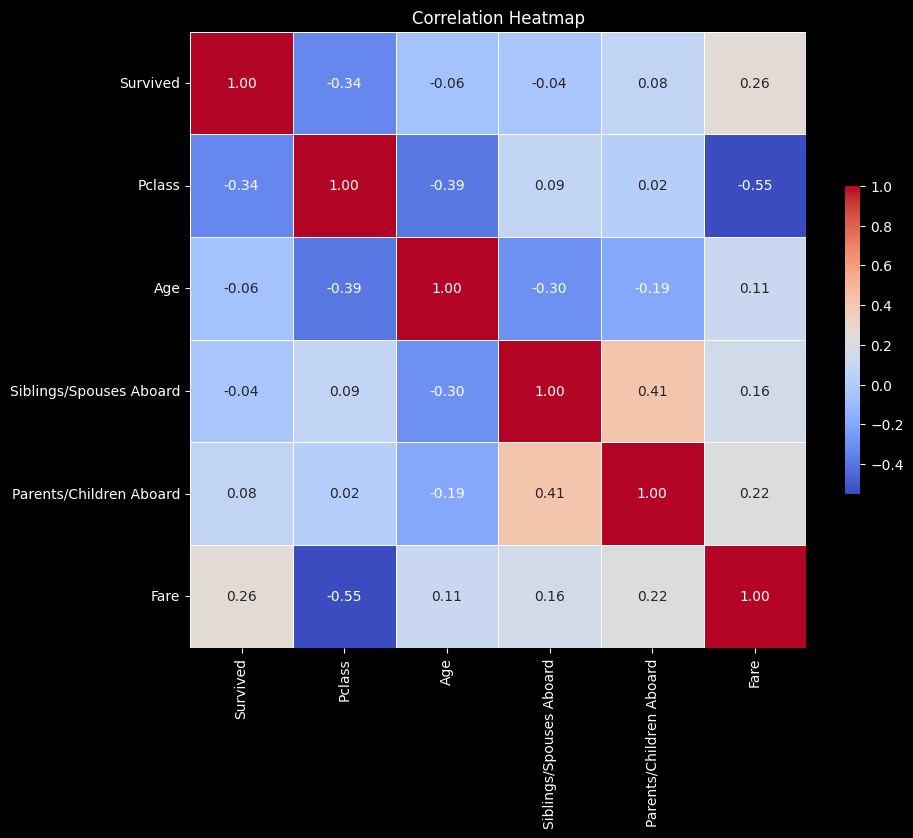


---- Code Ends ----


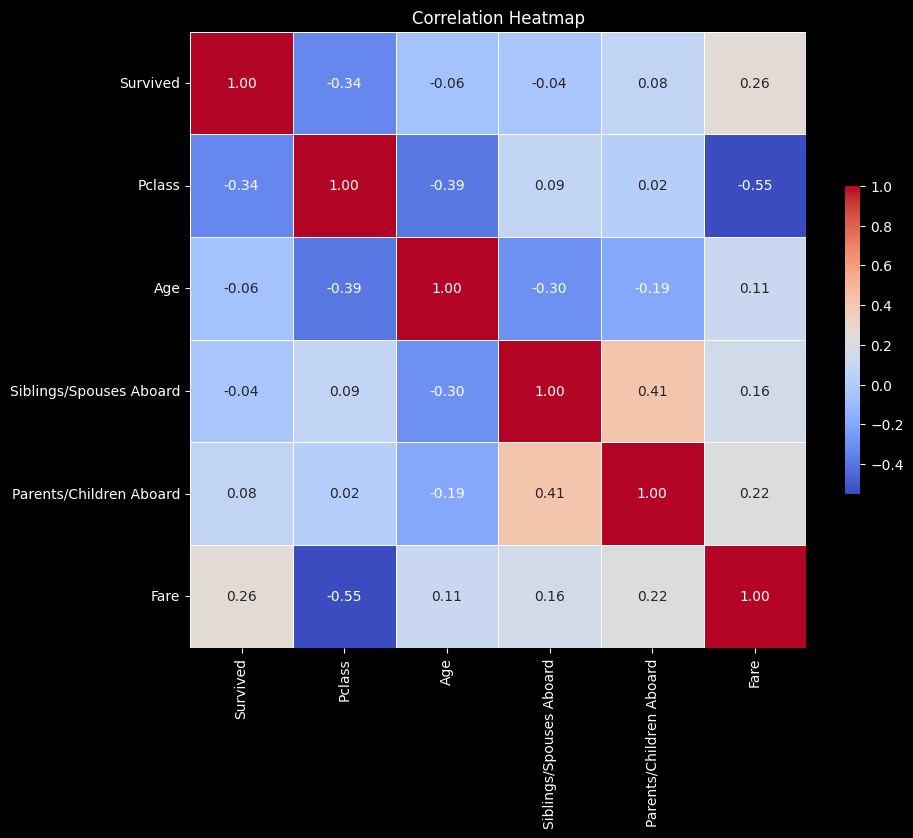

---- Message Begins ----

---- Message Ends ----
---- Final Answer Begins ----
I have visualized the correlations among the numeric columns in the dataset using a heatmap. The heatmap displays the correlation coefficients, with a color gradient representing the strength and direction of the correlations.
---- Final Answer Ends ----


In [11]:
stream_response("Visualize correlations as a heatmap.")

In [12]:
stream_response("How many rows are there?")

---- Code Begins ----
len(df)
887
---- Code Ends ----
---- Message Begins ----
887
---- Message Ends ----
---- Final Answer Begins ----
The DataFrame contains 887 rows.
---- Final Answer Ends ----


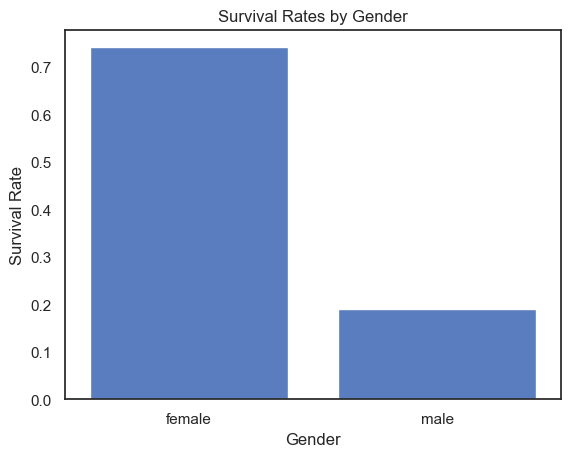

---- Code Begins ----
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate survival rates by gender
gender_survival_rates = df.groupby('Sex')['Survived'].mean()

# Plot the survival rates
sns.set_theme(style='white', palette='muted')
ax = sns.barplot(x=gender_survival_rates.index, y=gender_survival_rates.values)
ax.set_title('Survival Rates by Gender')
ax.set_ylabel('Survival Rate')
ax.set_xlabel('Gender')
plt.show()

---- Code Ends ----


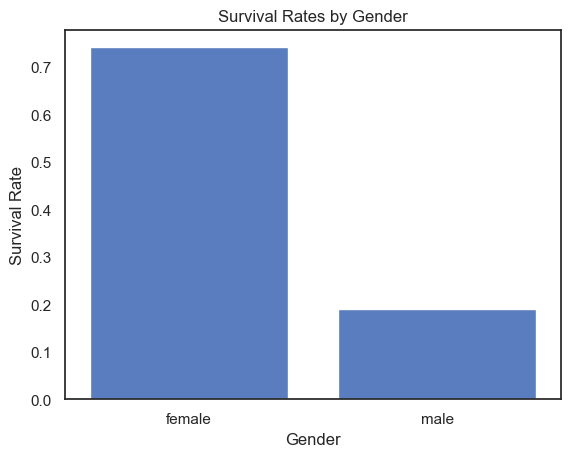

---- Message Begins ----

---- Message Ends ----
---- Final Answer Begins ----
The visualization above shows the difference in survival rates between men and women. The bar plot indicates that women had a higher survival rate compared to men.
---- Final Answer Ends ----


In [13]:
stream_response("What is the difference in survival rates between men and women?")

<string>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.



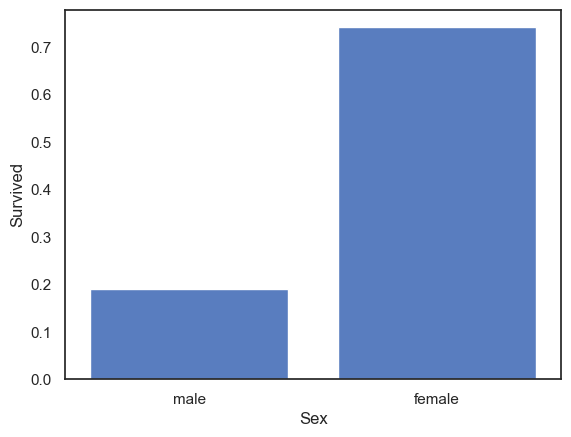

---- Code Begins ----
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style and palette
sns.set(style="white", palette="muted")

# Create a barplot for survival rates by gender
sns.barplot(x='Sex', y='Survived', data=df, ci=None)

# Show the plot
plt.show()

---- Code Ends ----


<string>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.



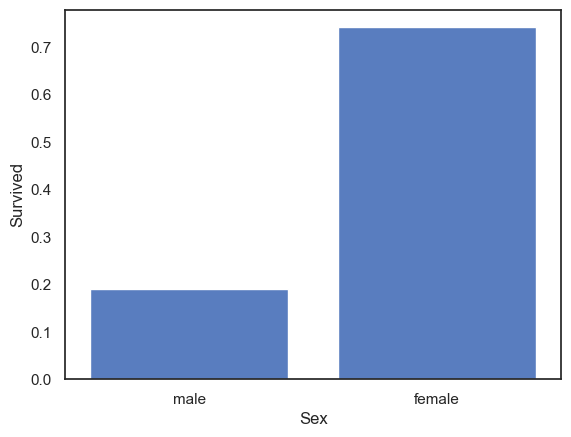

---- Message Begins ----

---- Message Ends ----
---- Final Answer Begins ----
The barplot visualizing the survival rates of male and female passengers has been displayed.
---- Final Answer Ends ----


In [14]:
stream_response(
    "Visualize the survival rates of male and female passengers in a barplot."
)

---- Code Begins ----
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame for children under 10 in 1st and 2nd class
children_df = df[(df['Age'] < 10) & (df['Pclass'].isin([1, 2]))]

# Create a bar plot for survival rates by sex
sns.set_theme(style="white", palette="muted")
plt.figure(figsize=(8, 6))
sns.barplot(data=children_df, x='Sex', y='Survived', hue='Pclass')
plt.title('Survival Rates of Male and Female Children Under 10 in 1st and 2nd Class')
plt.ylabel('Survival Rate')
plt.xlabel('Sex')
plt.legend(title='Pclass')
plt.show()


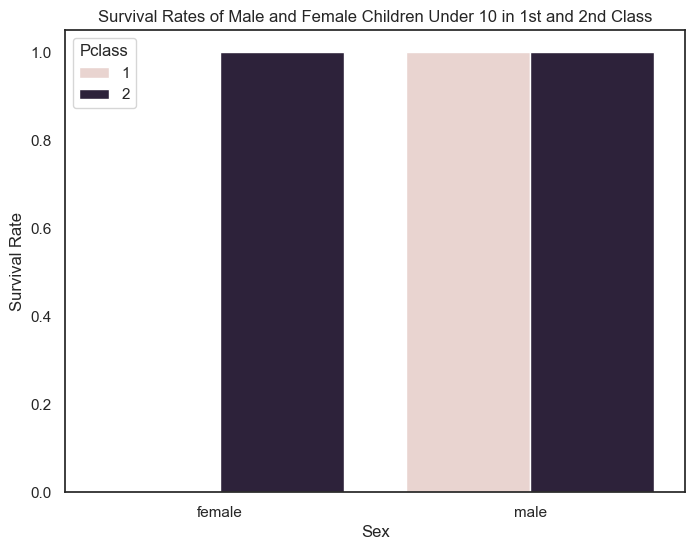


---- Code Ends ----


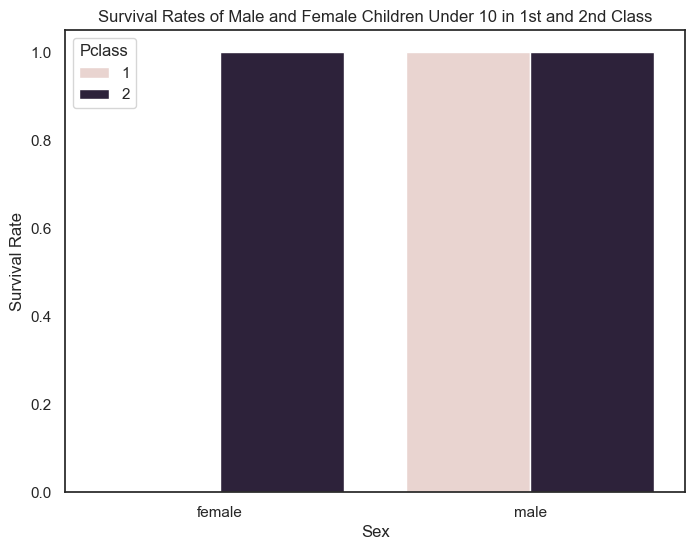

---- Message Begins ----

---- Message Ends ----
---- Final Answer Begins ----
The visualization of survival rates for male and female children under 10 in 1st and 2nd class has been generated.
---- Final Answer Ends ----


In [15]:
stream_response(
    "Visualize the survival rates of male and female children under 10 in 1st and 2nd class."
)